In [ ]:
!pip install tensorflow_privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers import dp_optimizer_keras
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer , DPKerasSGDOptimizer

In [ ]:
# Define paths
base_path = "/content/drive/MyDrive/Histopathology Imagery Dataset of Ph-Negative Myeloproliferative Neoplasm/"
et_path = os.path.join(base_path, "et")
mf_path = os.path.join(base_path, "mf")
pv_path = os.path.join(base_path, "pv")

# Load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    return images

et_images = load_images_from_folder(et_path)
mf_images = load_images_from_folder(mf_path)
pv_images = load_images_from_folder(pv_path)

# Create labels
et_labels = [0] * len(et_images)
mf_labels = [1] * len(mf_images)
pv_labels = [2] * len(pv_images)

# Combine data
X = np.array(et_images + mf_images + pv_images)
y = np.array(et_labels + mf_labels + pv_labels)

# Split pv class into 1/3 and remaining 2/3
pv_indices = np.where(y == 2)[0]
pv_train_indices, pv_extra_indices = train_test_split(pv_indices, test_size=2/3, random_state=42)

# Split dataset into two cases
train_indices_case1 = np.where(y != 2)[0].tolist() + pv_train_indices.tolist()
train_indices_case2 = np.arange(len(y))

X_train_case1 = X[train_indices_case1]
y_train_case1 = y[train_indices_case1]
X_train_case2 = X[train_indices_case2]
y_train_case2 = y[train_indices_case2]

# Normalize images
X_train_case1 = X_train_case1 / 255.0
X_train_case2 = X_train_case2 / 255.0

# Common validation set
X_train_common, X_val_common, y_train_common, y_val_common = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate validation set normalization
X_val_common = X_val_common / 255.0

In [ ]:
# Define data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

# Create augmented data generators
train_datagen_case1 = datagen.flow(X_train_case1, y_train_case1, batch_size=16)
train_datagen_case2 = datagen.flow(X_train_case2, y_train_case2, batch_size=16)


## VGG Model

In [ ]:
def build_vgg_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
def train_model_with_augmentation(model, train_datagen, X_val, y_val, epochs=50, batch_size=16):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_datagen,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                     patience=2,
                                                     verbose=1,
                                                     factor=0.3,
                                                     min_lr=0.000001)])
    return history

# Build models
vgg_model_case1 = build_vgg_model()
vgg_model_case2 = build_vgg_model()

# Train models on their respective datasets with augmentation
vgg_history_case1 = train_model_with_augmentation(vgg_model_case1, train_datagen_case1, X_val_common, y_val_common)
vgg_history_case2 = train_model_with_augmentation(vgg_model_case2, train_datagen_case2, X_val_common, y_val_common)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
15/15 [==============================] - 35s 1s/step - loss: 0.7940 - accuracy: 0.7597 - val_loss: 0.5526 - val_accuracy: 0.6167 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 4s 281ms/step - loss: 0.3350 - accuracy: 0.8283 - val_loss: 0.3700 - val_accuracy: 0.8833 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - 4s 253ms/step - loss: 0.4320 - accuracy: 0.8240 - val_loss: 0.4075 - val_accuracy: 0.8833 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8755
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
15/15 [==============================] - 5s 319ms/step - loss: 0.2861 - accuracy: 0.8755 - val_loss: 0.3785 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 5/50
15/15 [==============================] - 4s 268ms/step - loss: 0.2079 - accuracy: 0.9056 - val_loss: 0.2153 - val_accuracy: 0.9167

In [ ]:
# Get probabilistic outcomes from the common validation set
probs_case1 = vgg_model_case1.predict(X_val_common)
probs_case2 = vgg_model_case2.predict(X_val_common)

# Differences in probabilistic outcomes
diff_probs = np.abs(probs_case1 - probs_case2)

# Summarize results
print("Average difference in probabilistic outcomes:", np.mean(diff_probs))

2/2 [==============================] - 0s 153ms/step
Average difference in probabilistic outcomes: 0.03598448


In [ ]:
def plot_history(histories, titles):
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(titles[i])
        plt.legend()
        plt.show()

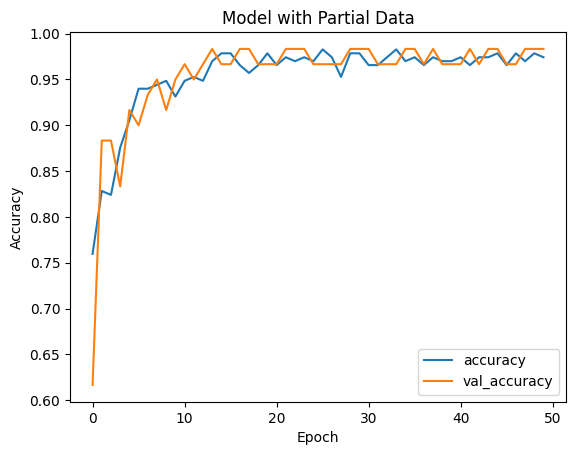

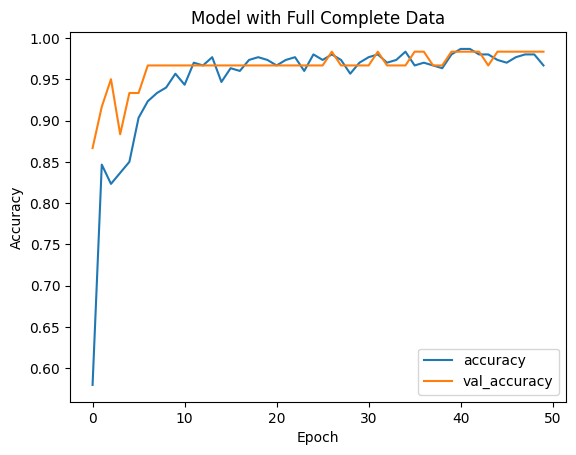

In [ ]:
# Visualize the accuracy and val_accuracy changes for both cases
plot_history([vgg_history_case1, vgg_history_case2], ['Model with Partial Data', 'Model with Full Complete Data'])

## Differential Privacy Model

Epoch 1/50
15/15 [==============================] - 12s 346ms/step - loss: 1.4425 - accuracy: 0.3262 - val_loss: 1.2196 - val_accuracy: 0.2833 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 4s 276ms/step - loss: 1.4015 - accuracy: 0.3219 - val_loss: 1.2137 - val_accuracy: 0.2333 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 1.4238 - accuracy: 0.2833
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
15/15 [==============================] - 5s 305ms/step - loss: 1.4238 - accuracy: 0.2833 - val_loss: 1.2155 - val_accuracy: 0.2167 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - 5s 309ms/step - loss: 1.2901 - accuracy: 0.3433 - val_loss: 1.2132 - val_accuracy: 0.2167 - lr: 3.0000e-05
Epoch 5/50
15/15 [==============================] - ETA: 0s - loss: 1.3890 - accuracy: 0.3348
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
15/15 [==========================

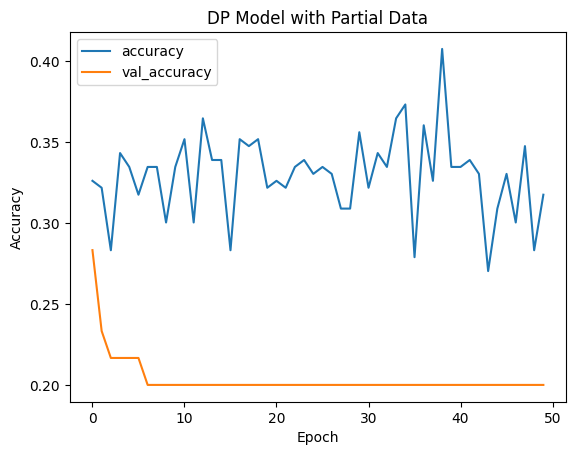

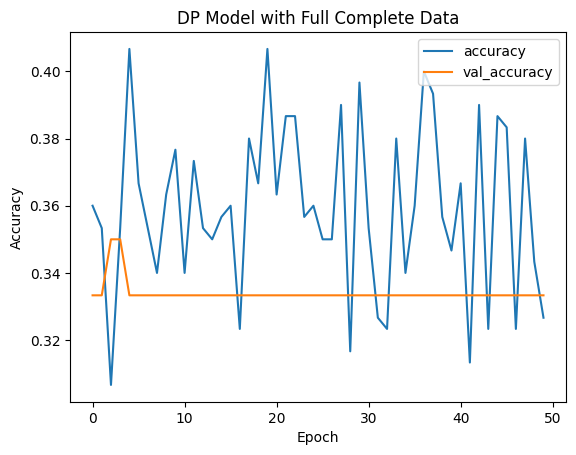

In [ ]:

def train_model_with_dp(model, train_datagen, X_val, y_val, epochs=50, batch_size=16, noise_multiplier=1.1, l2_norm_clip=1.0, microbatches=1):
    optimizer = DPKerasAdamOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=microbatches,
        learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_datagen,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                     patience=2,
                                                     verbose=1,
                                                     factor=0.3,
                                                     min_lr=0.000001)])
    return history

# Build models
dp_model_case1 = build_vgg_model()
dp_model_case2 = build_vgg_model()

# Train models on their respective datasets with DP and augmentation
dp_history_case1 = train_model_with_dp(dp_model_case1, train_datagen_case1, X_val_common, y_val_common)
dp_history_case2 = train_model_with_dp(dp_model_case2, train_datagen_case2, X_val_common, y_val_common)

# Get probabilistic outcomes from the common validation set
probs_dp_case1 = dp_model_case1.predict(X_val_common)
probs_dp_case2 = dp_model_case2.predict(X_val_common)

# Differences in probabilistic outcomes
diff_probs_dp = np.abs(probs_dp_case1 - probs_dp_case2)

# Summarize results
print("Average difference in probabilistic outcomes with DP:", np.mean(diff_probs_dp))



# Visualize the accuracy and val_accuracy changes for both cases
plot_history([dp_history_case1, dp_history_case2], ['DP Model with Partial Data', 'DP Model with Full Complete Data'])

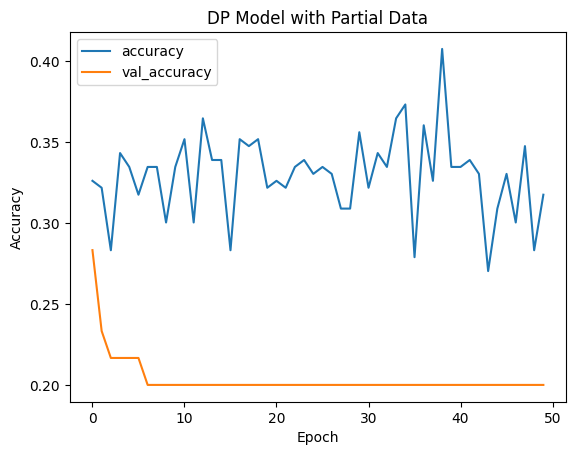

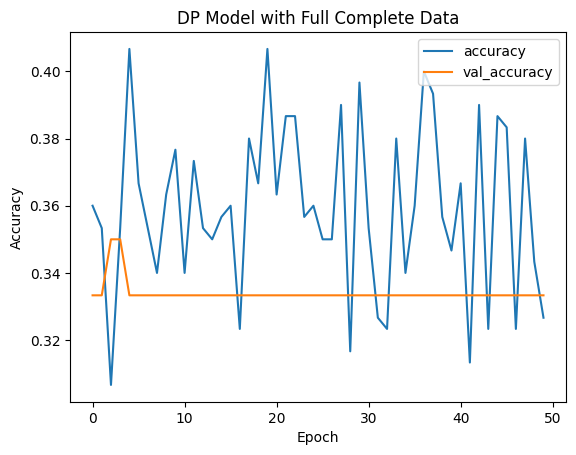

In [ ]:
plot_history([dp_history_case1, dp_history_case2], ['vgg with DP Model with Partial Data', 'vgg with DP Model with Full Complete Data'])

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
15/15 [==============================] - 47s 663ms/step - loss: 0.9142 - accuracy: 0.8197 - val_loss: 9.1296 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 5s 323ms/step - loss: 0.6855 - accuracy: 0.9185 - val_loss: 20.6071 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.7835 - accuracy: 0.9313
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
15/15 [==============================] - 4s 252ms/step - loss: 0.7835 - accuracy: 0.9313 - val_loss: 65.0511 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - 4s 276ms/step - loss: 0.3322 - accuracy: 0.9571 - val_loss: 33.6230 - val_accuracy: 0.3667 - lr: 3.0000e-05
Epoch 5/50
15/15 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9957
Epoch 5: ReduceLROnPlateau reducing learn

2/2 [==============================] - 6s 2s/step


2/2 [==============================] - 1s 122ms/step
Average difference in probabilistic outcomes: 0.24202088


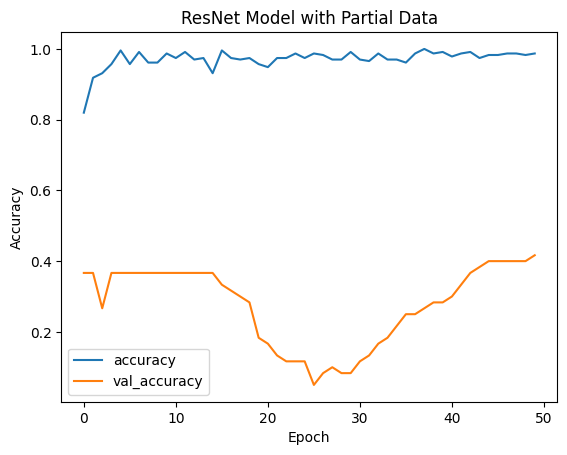

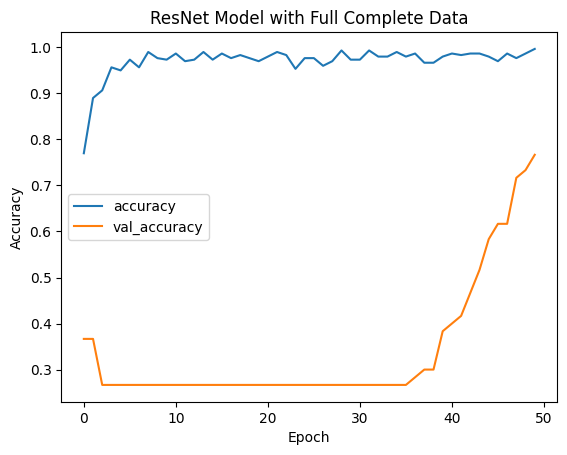

In [ ]:
# Define the ResNet model
def build_resnet_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Train the model with data augmentation
def train_model_with_augmentation(model, train_datagen, X_val, y_val, epochs=50, batch_size=16):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_datagen,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                     patience=2,
                                                     verbose=1,
                                                     factor=0.3,
                                                     min_lr=0.000001)])
    return history

# Build models
resnet_model_case1 = build_resnet_model()
resnet_model_case2 = build_resnet_model()

# Train models on their respective datasets with augmentation
resnet_history_case1 = train_model_with_augmentation(resnet_model_case1, train_datagen_case1, X_val_common, y_val_common)
resnet_history_case2 = train_model_with_augmentation(resnet_model_case2, train_datagen_case2, X_val_common, y_val_common)

# Get probabilistic outcomes from the common validation set
probs_case1 = resnet_model_case1.predict(X_val_common)
probs_case2 = resnet_model_case2.predict(X_val_common)

# Differences in probabilistic outcomes
diff_probs = np.abs(probs_case1 - probs_case2)

# Summarize results
print("Average difference in probabilistic outcomes:", np.mean(diff_probs))

# Plot training history
plot_history([resnet_history_case1, resnet_history_case2], ['ResNet Model with Partial Data', 'ResNet Model with Full Complete Data'])

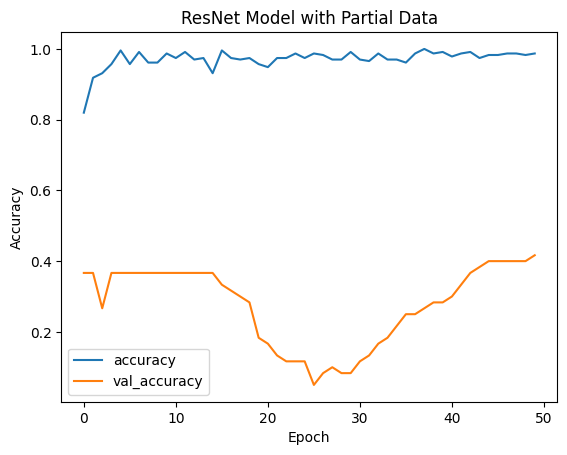

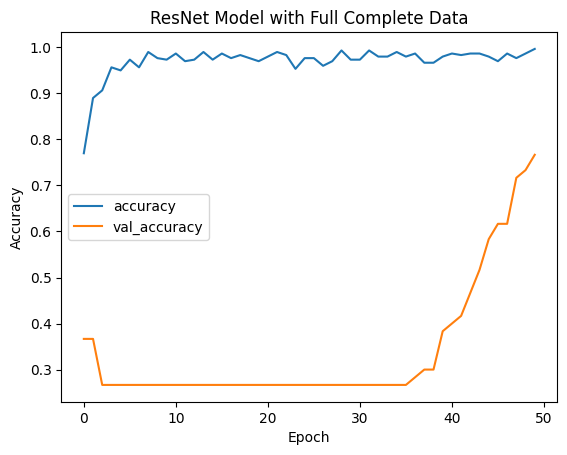

In [ ]:
plot_history([resnet_history_case1, resnet_history_case2], ['ResNet Model with Partial Data', 'ResNet Model with Full Complete Data'])

In [ ]:

def train_model_with_dp(model, train_datagen, X_val, y_val, epochs=50, batch_size=16, noise_multiplier=1.1, l2_norm_clip=1.0, microbatches=1):
    optimizer = DPKerasAdamOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=microbatches,
        learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_datagen,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                     patience=2,
                                                     verbose=1,
                                                     factor=0.3,
                                                     min_lr=0.000001)])
    return history

# Build models
dp_model_case1 = build_resnet_model()
dp_model_case2 = build_resnet_model()

# Train models on their respective datasets with DP and augmentation
dp_history_case1 = train_model_with_dp(dp_model_case1, train_datagen_case1, X_val_common, y_val_common)
dp_history_case2 = train_model_with_dp(dp_model_case2, train_datagen_case2, X_val_common, y_val_common)

# Get probabilistic outcomes from the common validation set
probs_dp_case1 = dp_model_case1.predict(X_val_common)
probs_dp_case2 = dp_model_case2.predict(X_val_common)

# Differences in probabilistic outcomes
diff_probs_dp = np.abs(probs_dp_case1 - probs_dp_case2)

# Summarize results
print("Average difference in probabilistic outcomes with DP:", np.mean(diff_probs_dp))




Epoch 1/50
15/15 [==============================] - 47s 375ms/step - loss: 2.7794 - accuracy: 0.3004 - val_loss: 1.2591 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 5s 329ms/step - loss: 2.8576 - accuracy: 0.3262 - val_loss: 1.1351 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - 4s 280ms/step - loss: 2.7361 - accuracy: 0.3433 - val_loss: 1.1277 - val_accuracy: 0.3833 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - 5s 325ms/step - loss: 2.7135 - accuracy: 0.3262 - val_loss: 1.1237 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 5/50
15/15 [==============================] - 5s 330ms/step - loss: 2.8398 - accuracy: 0.2876 - val_loss: 1.1525 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 6/50
15/15 [==============================] - 6s 374ms/step - loss: 2.8592 - accuracy: 0.2790 - val_loss: 1.2588 - val_accuracy: 0.3833 - lr: 1.0000e-04
Epoch 7/50
15/15 [===========================

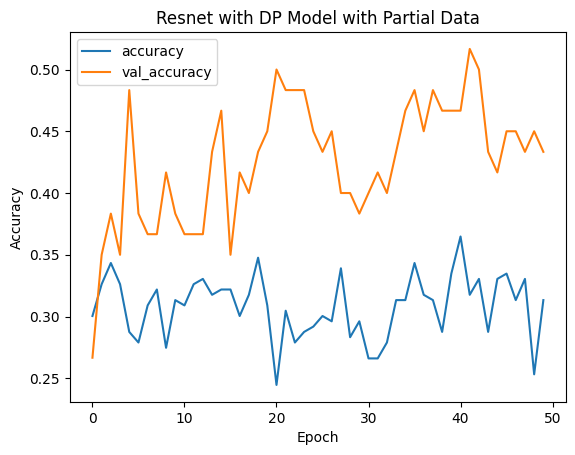

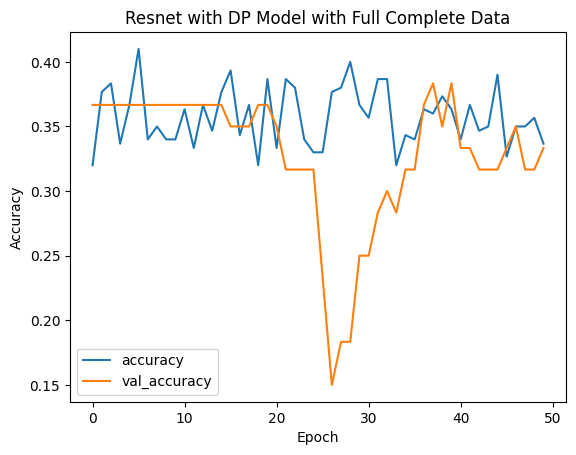

In [ ]:
plot_history([dp_history_case1, dp_history_case2], ['Resnet with DP Model with Partial Data', 'Resnet with DP Model with Full Complete Data'])

Inception Model


In [ ]:
# Define the InceptionV3 model
def build_inception_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x) # Reduce the number of units in the Dense layer
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Train the model with data augmentation
def train_model_with_augmentation(model, train_datagen, X_val, y_val, epochs=50, batch_size=16):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_datagen,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                     patience=2,
                                                     verbose=1,
                                                     factor=0.3,
                                                     min_lr=0.000001)])
    return history

# Build models
inception_model_case1 = build_inception_model()
inception_model_case2 = build_inception_model()

# Train models on their respective datasets with augmentation
inception_history_case1 = train_model_with_augmentation(inception_model_case1, train_datagen_case1, X_val_common, y_val_common)
inception_history_case2 = train_model_with_augmentation(inception_model_case2, train_datagen_case2, X_val_common, y_val_common)

# Get probabilistic outcomes from the common validation set
probs_case1 = inception_model_case1.predict(X_val_common)
probs_case2 = inception_model_case2.predict(X_val_common)

# Differences in probabilistic outcomes
diff_probs = np.abs(probs_case1 - probs_case2)

# Summarize results
print("Average difference in probabilistic outcomes:", np.mean(diff_probs))

# Plot training history
plot_history([inception_model_case1, inception_model_case2], ['Inception Model with Partial Data', 'Inception Model with Full Complete Data'])

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/50
15/15 [==============================] - 51s 830ms/step - loss: 1.4106 - accuracy: 0.5923 - val_loss: 3.6533 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 6s 412ms/step - loss: 0.8343 - accuracy: 0.7597 - val_loss: 1.1297 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - 3s 209ms/step - loss: 0.3610 - accuracy: 0.8584 - val_loss: 2.2729 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - 4s 278ms/step - loss: 0.2296 - accuracy: 0.9013 - val_loss: 0.7938 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 5/50
15/15 [==============================] - 4s 258ms/step - loss: 0.1414 - accuracy: 0.9442 - val_loss: 0.8466 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 6/50
15/15 [==============================] - 3s 212ms/step - loss: 0.1137 - accuracy: 0.9528 - val_loss: 0.6391 - val_accuracy: 0.78

TypeError: 'History' object is not subscriptable

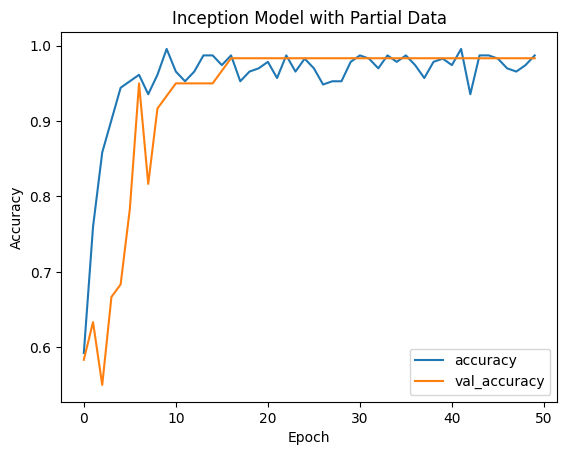

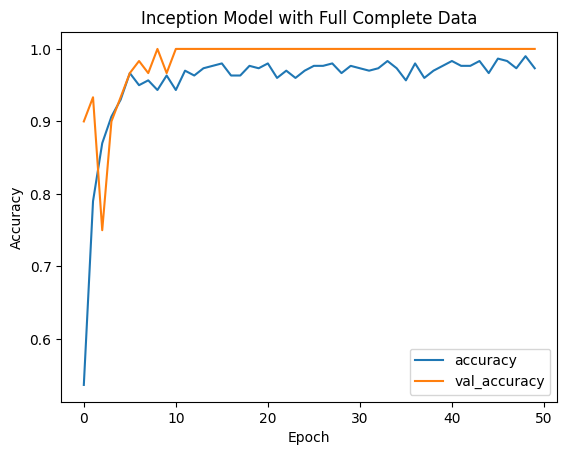

In [ ]:

plot_history([inception_history_case1, inception_history_case2], ['Inception Model with Partial Data', 'Inception Model with Full Complete Data'])

In [ ]:
def train_model_with_dp(model, train_datagen, X_val, y_val, epochs=50,
                        batch_size=4, # Further reduce batch size
                        noise_multiplier=1.1, l2_norm_clip=1.0, microbatches=1):
    optimizer = DPKerasAdamOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=microbatches,
        learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_datagen,
                        epochs=epochs,
                        batch_size=batch_size, # Use the reduced batch size
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                     patience=2,
                                                     verbose=1,
                                                     factor=0.3,
                                                     min_lr=0.000001)])
    return history

# Build models
dp_model_case1 = build_inception_model(input_shape=(224, 224, 3), num_classes=3) # Explicitly pass input shape and number of classes
dp_model_case2 = build_inception_model(input_shape=(224, 224, 3), num_classes=3) # Explicitly pass input shape and number of classes

# Train models on their respective datasets with DP and augmentation
dp_history_case1 = train_model_with_dp(dp_model_case1, train_datagen_case1, X_val_common, y_val_common)
dp_history_case2 = train_model_with_dp(dp_model_case2, train_datagen_case2, X_val_common, y_val_common)

# Get probabilistic outcomes from the common validation set
probs_dp_case1 = dp_model_case1.predict(X_val_common)
probs_dp_case2 = dp_model_case2.predict(X_val_common)

# Differences in probabilistic outcomes
diff_probs_dp = np.abs(probs_dp_case1 - probs_dp_case2)

# Summarize results
print("Average difference in probabilistic outcomes with DP:", np.mean(diff_probs_dp))





Epoch 1/50
15/15 [==============================] - 62s 536ms/step - loss: 1.9360 - accuracy: 0.2060 - val_loss: 1.3248 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 4s 241ms/step - loss: 1.8597 - accuracy: 0.2189 - val_loss: 1.2730 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 1.8446 - accuracy: 0.2275
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
15/15 [==============================] - 4s 243ms/step - loss: 1.8446 - accuracy: 0.2275 - val_loss: 1.2729 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - 5s 309ms/step - loss: 1.9813 - accuracy: 0.2318 - val_loss: 1.2809 - val_accuracy: 0.4333 - lr: 3.0000e-05
Epoch 5/50
15/15 [==============================] - ETA: 0s - loss: 2.0078 - accuracy: 0.2017
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
15/15 [==========================

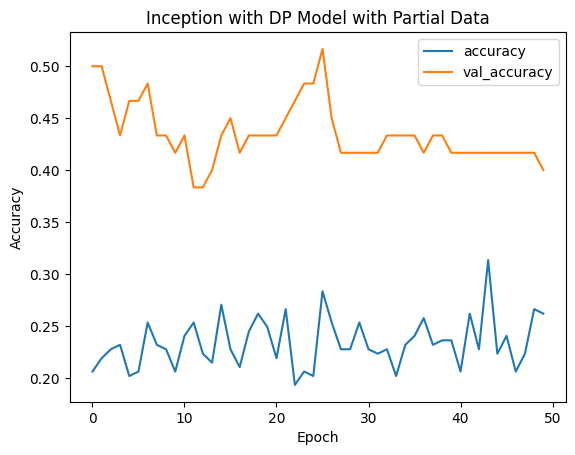

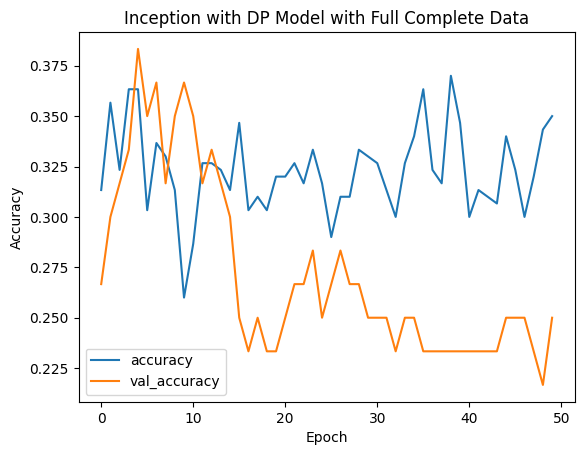

In [ ]:
# Visualize the accuracy and val_accuracy changes for both cases
plot_history([dp_history_case1, dp_history_case2], ['Inception with DP Model with Partial Data', 'Inception with DP Model with Full Complete Data'])

In [ ]:

# Define the custom CNN model
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x) # Reduce the number of neurons in this layer
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

# Define DP optimizer function (same as before)
def create_dp_optimizer(learning_rate, noise_multiplier, l2_norm_clip, num_microbatches):
    optimizer = DPKerasSGDOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=num_microbatches,
        learning_rate=learning_rate)
    return optimizer

# Train the custom CNN model with DP (same function as before)
def train_model_with_dp(model, train_datagen, X_val, y_val, epochs=5, batch_size=32, # Changed batch size to 32
                        noise_multiplier=1.1, l2_norm_clip=1.0, num_microbatches=16):
    optimizer = create_dp_optimizer(learning_rate=0.001, noise_multiplier=noise_multiplier,
                                   l2_norm_clip=l2_norm_clip, num_microbatches=num_microbatches)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_datagen,
                        epochs=epochs,
                        batch_size=batch_size, # Use the modified batch size
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=[ReduceLROnPlateau(monitor='val_accuracy',
                                                     patience=2,
                                                     verbose=1,
                                                     factor=0.3,
                                                     min_lr=0.000001)])
    return history


# Build and train custom CNN model with DP
custom_cnn_model_dp_case1 = build_custom_cnn()
custom_cnn_model_dp_case2 = build_custom_cnn()

# Train models on their respective datasets with DP
custom_cnn_dp_history_case1 = train_model_with_dp(custom_cnn_model_dp_case1, train_datagen_case1, X_val_common, y_val_common)
custom_cnn_dp_history_case2 = train_model_with_dp(custom_cnn_model_dp_case2, train_datagen_case2, X_val_common, y_val_common)

# Get probabilistic outcomes from the common validation set
custom_cnn_dp_probs_case1 = custom_cnn_model_dp_case1.predict(X_val_common)
custom_cnn_dp_probs_case2 = custom_cnn_model_dp_case2.predict(X_val_common)

# Differences in probabilistic outcomes
custom_cnn_dp_diff_probs = np.abs(custom_cnn_dp_probs_case1 - custom_cnn_dp_probs_case2)

# Summarize results
print("Average difference in DP probabilistic outcomes for custom CNN:", np.mean(custom_cnn_dp_diff_probs))

# Plot training history for custom CNN DP models
plot_history([custom_cnn_dp_history_case1, custom_cnn_dp_history_case2], ['DP Custom CNN Model with Partial Data', 'DP Custom CNN Model with Full Complete Data'])


Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 598, in minimize
        grads_and_vars = self._compute_gradients(
    File "/usr/local/lib/python3.10/dist-packages/tensorflow_privacy/privacy/optimizers/dp_optimizer_keras.py", line 277, in _compute_gradients
        tf.reshape(loss, [num_microbatches, -1]), axis=1)

    ValueError: Dimension size must be evenly divisible by 16 but is 1 for '{{node Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](sparse_categorical_crossentropy/weighted_loss/value, Reshape/shape)' with input shapes: [], [2] and with input tensors computed as partial shapes: input[1] = [16,?].
